# PCST reductions on Road Maps
#This example retrieves a graph from [OpenStreetMap](https://www.openstreetmap.org) via the [osmnx](https://osmnx.readthedocs.io) package.
#Blablabla

## Imports

In [1]:
import random
import networkx as nx

import osmnx as ox
import pyproj
import time

from graphilp.imports import networkx as imp_nx
from graphilp.network import pcst_linear as stp
from graphilp.network.reductions import pcst_utilities as pu
from graphilp.network.reductions import pcst_basic_reductions as br
from graphilp.network.reductions import pcst_voronoi as vor
from graphilp.network.reductions import pcst_dualAscent as da

## Choose reduction techniques

In [2]:
# Choose which reduction techniques to use
basic_reductions_active = False
voronoi_active = True
dualAscent_active = True

# Variables for time evaluation
basic_reductions_time = 0
voronoi_time = 0
dualAscent_time = 0
gurobi_with_reductions_time = 0
gurobi_without_reductions_time = 0

# Variables for adding more constraints based on reductions
term_deg2 = None
nodes_deg3 = None
fixed_terminals = None

## Set up the graph

In [3]:
crs = pyproj.crs.CRS('epsg:31467')

In [4]:
place = 'Carlstadt, Düsseldorf, Deutschland'

# road network of suburb (converted to Gauss-Krüger 3)
G_ox = ox.project_graph(ox.graph_from_place(place, network_type='walk'), to_crs=crs)


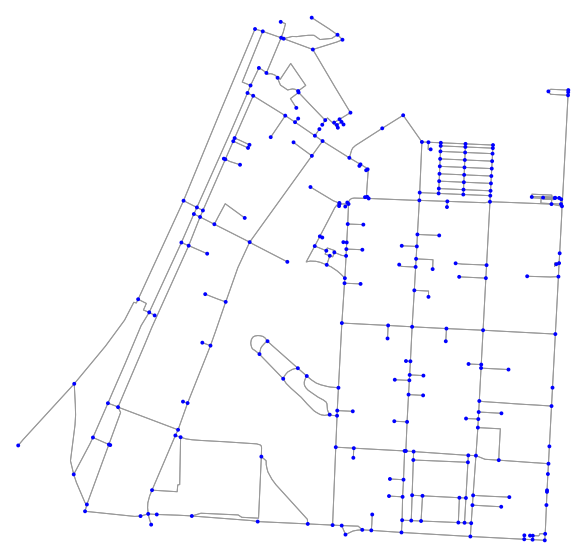

In [5]:
#draw the road map
ox.plot_graph(G_ox, figsize=(14, 10),
              bgcolor='#FFF',
              node_color='b');

In [6]:
node_list = list(G_ox.nodes())

In [7]:
# choose random terminals
num_terminals = 5
terminals = [node_list[random.randint(0, len(node_list))] for n in range(num_terminals)]
terminals = [316776963, 4185973923, 4028758242, 1561453930, 584047465]

print(terminals)

[316776963, 4185973923, 4028758242, 1561453930, 584047465]


In [8]:
# Set up the profit of the nodes (What is the profit of terminals?)
for node in G_ox.nodes():
    if node in terminals:
        G_ox.nodes[node]['prize'] = 300
    else:
        G_ox.nodes[node]['prize'] = 0

In [9]:
#Set up a root
root = terminals[0]
print("Root: ", root)

Root:  316776963


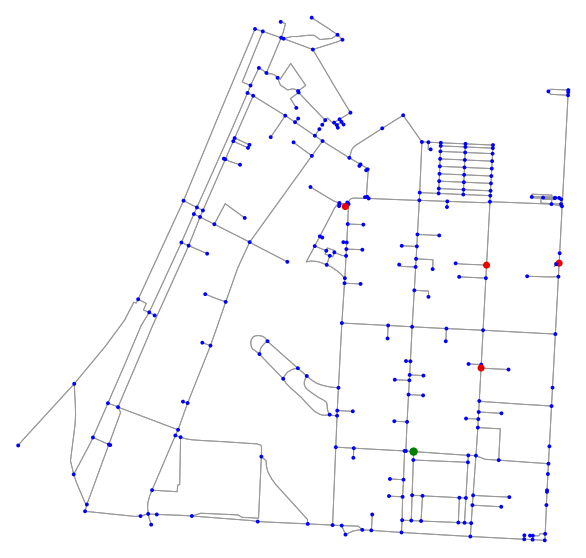

In [10]:
# draw road map and terminals
ox.plot_graph(G_ox, figsize=(14, 10),
    bgcolor='#FFF',
    node_color=['g' if n == root else'#ED0000' if n in terminals else '#00F' for n in node_list],
    node_size=[70 if n == root else 50 if n in terminals else 15 for n in node_list]);

In [11]:
# Print size of graph
pu.show_graph_size(G_ox, "Original graph: ")

TypeError: show_graph_size() missing 1 required positional argument: 'file'

In [ ]:
# Transformation of the MultiDiGraph to a DiGraph because Networkx doesn't fully support Multigraphs.
G = nx.Graph(G_ox)
for e in G.edges():
    G.edges[e]['weight'] = G.get_edge_data(e[0], e[1])['length']




## Solve the instance without any reductions for comparison

In [ ]:
if True:
    optG = imp_nx.read(G)
    # Solve the instance without any reductions for comparison
    time_start = time.time()
    m = stp.create_model(optG, terminals, weight='weight')
    m.optimize()
    best_val = m.objVal
    time_end = time.time()
    solution = stp.extract_solution(optG, m)
    #solution, best_val = pu.gurobi(G, root)
    #solution, best_val = 0, 0
    #solution = [(595793277, 1561453934), (1561453933, 595793277), (596188953, 1561453933), (584047447, 1561453932), (584047465, 584047447), (584047465, 4278832131), (1561453932, 596188953), (1561453964, 584047465), (5093054218, 1561453964), (5093054218, 4028758284), (1561453966, 5093054218), (3314944014, 1561453966), (3314944014, 3314944018), (4028758284, 8096912481), (8096912481, 8096912480)]


In [ ]:
if True:
    node_list1 = [u for (u, v) in solution]
    node_list2 = [v for (u, v) in solution]
    res_node_list = list(set(node_list1 + node_list2))
    res_terminals = [t for t in res_node_list if t in terminals]
    edge_colors = ['#ED0000' if (u, v) in solution or (v, u) in solution else '#AAA' for u, v in G_ox.edges()]
    edge_widths = [3 if (u, v) in solution else 1 for u, v in G_ox.edges()]

    ox.plot_graph(G_ox, figsize=(14, 10),
                  bgcolor='#FFF',
                  node_color=['red' if n == root else '#ED0000' if n in res_terminals else "blue" if n in res_node_list else 'white' for n in node_list],
                  node_size=[80 if n == root else 60 if n in res_terminals else 15 for n in node_list],
                  edge_color=edge_colors, edge_linewidth=edge_widths);

    gurobi_without_reductions_time = time_end - time_start

    print("\nGurobi took " + str(gurobi_without_reductions_time) + " Seconds to compute.")
    print("Edges in solution (for debugging): ", solution, "\n")

## Use Reductions

### Basic Reductions

In [ ]:
if basic_reductions_active:
    time_start = time.time()
    br.basic_reductions(G, root)
    # Print size of graph
    pu.show_graph_size(G, "Basic reductions: ")
    time_end = time.time()
    basic_reductions_time = time_end - time_start
    print("Basic reductions took " + str(basic_reductions_time) + " Seconds to compute.\n")



### Voronoi

In [ ]:
if voronoi_active:
    time_start = time.time()
    try:
        term_deg2, nodes_deg3 = vor.reductionTechniques(G, root)
    except KeyError:
        # If PCST fast throws a Key Error the upper bound solution is only the root note and therefore the real solution is only the root node.
        print("Pcst-fast found only Root note, no Graph for the upperBound could be built. Solution is trivial.")
        nodes_to_remove = [n for n in G.nodes if n != root and n not in list(G.neighbors(root))]
        G.remove_nodes_from(nodes_to_remove)
    pu.show_graph_size(G, "Voronoi: ")
    time_end = time.time()
    voronoi_time = time_end - time_start
    print("Voronoi took " + str(voronoi_time) + " Seconds to compute.\n")

### Dual Ascent

In [ ]:

if dualAscent_active:
    time_start = time.time()
    try:
        G, fixed_terminals = da.dual_ascent_tests(G, root)
    except KeyError:
        # If PCST fast throws a Key Error the upper bound solution is only the root note and therefore the real solution is only the root node.
        print("Pcst-fast found only Root note, no Graph for the upperBound could be built. Solution is trivial.")
        nodes_to_remove = [n for n in G.nodes if n != root and n not in list(G.neighbors(root))]
        G.remove_nodes_from(nodes_to_remove)
    pu.show_graph_size(G, "Dual Ascent: ")
    time_end = time.time()
    dualAscent_time = time_end - time_start
    print("Dual Ascent took " + str(dualAscent_time) + " Seconds to compute.\n")

for e in solution:
    if e not in G.edges:
        print("aesröjgtpasiohjgt" , e)
    else:
        print("OK")

## Plot graph after reduction

In [ ]:
terminals = [t for t in G.nodes() if G.nodes[t]['prize'] > 0]
node_list_after_reduction = list(G.nodes())

edge_colors = ["black" if (u, v) == (584047447, 1561453932) else '#ED0000' if (u, v) in G.edges() or (v, u) in G.edges() else '#AAA' for u, v in G_ox.edges()]
edge_widths = [3 if (u, v) in G.edges() else 1 for u, v in G_ox.edges()]

ox.plot_graph(G_ox, figsize=(14, 10),
              bgcolor='#FFF',
              node_color=['red' if n == root else '#ED0000' if n in terminals else "blue" if n in node_list_after_reduction else'white' for n in
                          node_list],
              node_size=[80 if n == root else 60 if n in terminals else 15 for n in node_list],
              edge_color=edge_colors, edge_linewidth=edge_widths);

# Use gurobi to run the optimisation problem

In [ ]:
time_start = time.time()
solution, best_val_red = pu.gurobi(G, root, False, term_deg2, nodes_deg3, False, fixed_terminals)
time_end = time.time()
gurobi_with_reductions_time = time_end - time_start

print("\nGurobi took " + str(gurobi_with_reductions_time) + " Seconds to compute.")
print("Edges in solution (for debugging): ", solution, "\n")

## Plot the solution

In [ ]:
node_list1 = [u for (u, v) in solution]
node_list2 = [v for (u, v) in solution]
res_node_list = list(set(node_list1 + node_list2))
res_terminals = [t for t in res_node_list if t in terminals]


edge_colors = ['#ED0000' if (u, v) in solution or (v, u) in solution else '#AAA' for u, v in G_ox.edges()]
edge_widths = [3 if (u, v) in solution else 1 for u, v in G_ox.edges()]

ox.plot_graph(G_ox, figsize=(14, 10),
              bgcolor='#FFF',
              node_color=['red' if n == root else '#ED0000' if n in res_terminals else "blue" if n in res_node_list else 'white' for n in node_list],
              node_size=[80 if n == root else 60 if n in res_terminals else 15 for n in node_list],
              edge_color=edge_colors, edge_linewidth=edge_widths);


## Compare times used

In [ ]:
print("Time without reductions: ", gurobi_without_reductions_time, ".")
print("Time with reductions: ", str((basic_reductions_time) + voronoi_time + dualAscent_time + gurobi_with_reductions_time), ".")
print("Obj. value without reductions: ", best_val)
print("Obj. value with reductions: ", best_val_red)